# Data choosing and filtering


description for the method:

first position : Madgwick(x,y,z,w)  and Mocap(x,y,z,w) <br>
possible quat transformations method: <br>
Madgwick(x,y,z,w)----(w_flip)---->Madgwick(w,x,y,z)----(quat_turn)----> Mocap(w,-y,x,-z)----(MAD_to_MOC)---->Mocap(w,x,y,z)----(w_back_flip)---->Mocap(x,y,z,w)

Madgwick(x,y,z,w)----(w_flip)---->Madgwick(w,x,y,z)----(MAD_to_MOC)---->Madgwick(w,y-x-z)----(quat_turn)---->Mocap(w,x,y,z)----(w_back_flip)---->Mocap(x,y,z,w)

#### ================Madgwick algortihm======================<br>
The method we're goin to use:<br>

1st step:<br>
Madgwick(x,y,z,w)----(w_flip)---->Madgwick(w,x,y,z)----(quat_turn)----> Mocap(w,-y,x,-z) ======>Moctest(w,x,y,z)<br>

2nd step:<br>
Mocap(x,y,z,w)----(w_flip)---->Mocap(w,x,y,z)----(MOC_to_MAD)---->Mocap(w,-y,x,-z) =======>MocapQ(w,x,y,z)<br>
at this point we do a comparison with graphs<br>

#### ===============Transformer network========================<br>
for the transformer netwrok:<br>
we want to do a comparison with the Madgwick algorithm, which works like this:<br>
Madgwick(Acc,Gyr,Mag)===>Madgwick(x,y,z,w) = (w_back_flip(quat_turn(MOC_to_MAD(w_flip(Mocap(x,y,z,w))))))<br>

therefore, we want to teach our network the following process:<br>
Transformer(Acc,Gyr,Mag)===>w_back_flip(quat_turn(w_flip(Madgwick(x,y,z,w))))=Mocap(-y,x,-z,w)<br>
we want to teach the network this process, because the quat_turn function needs values from the madgwick quaternions, and we want a independent system<br>
so the trnasformation should look like something like this:<br>

Transformer(Acc,Gyr,Mag)===>Mocap(-y,x,-z,w)----(w_flip)---->Mocap(-y,x,-z,w) ======>(Xcoord,Ycoord,Zcoord,Wcoord)<br>
So the Transformer target values should be: Mocap(x,y,z,w)----(w_flip)---->Mocap(w,x,y,z)----(MOC_to_MAD)---->Mocap(w,-y,x,-z)----(w_back_flip)---->Mocap(-y,x,-z,w)<br>

at this point we can compare all of our results with graphs<br>
we have to keep in mind, that the tarnsformer network will give values only form the 128th step<br>

#### ==============Euler representation=====================<br>
The functio we are using needs the quaternions in this shape: quat(w,x,y,z)<br>
lets call this function: Euler<br>
so Mocap(w,x,y,z)----(Euler)---->Mocap(a,b,g)=~=MocapE<br>

so we have to transform our quaternion in the shape shown before:<br>
Moctest(w,x,y,z) = Mocap(w,-y,x,-z)----(MAD_to_MOC)---->Mocap(w,x,y,z)----(Euler)---->MadEuler(a,b,g)<br>
MocapQ(w,x,y,z) =  Mocap(w,-y,x,-z)----(MAD_to_MOC)---->Mocap(w,x,y,z)----(Euler)---->MocapE(a,b,g) <br>

in theory we could use MocapE here, but our Euler function doesn't tranform MocapQ into MocapE precisely unfortunately<br>
quat(Xcoord,Ycoord,Zcoord,Wcoord) = Mocap(w,-y,x,-z)----(MAD_to_MOC)---->Mocap(w,x,y,z)----(Euler)---->TransformE(a,b,g)<br>

now we can represent the differences between the mocap and madgwick algortihm and aldo between the mocap and the the transform network <br>
also we can compare the two methods: Madgwick and Trnasform<br>

This was the Theory, this how we implemented it:<br>

In [1]:
'''
folder = str("../logs/20201002_10_16_28/") # Y up Stand still 
folder = str("../logs/20201002_10_17_42/") # Y up Calib for Magneto
folder = str("../logs/20201002_10_19_33/") # Y up Test
folder = str("../logs/20201002_11_03_27/") # Z up Stand still
folder = str("../logs/20201002_11_03_37/") # Z up Calib for magneto
folder = str("../logs/20201002_11_04_35/") # Z up Test
folder = str("../logs/20201002_11_05_25/") # Z up Training 
folder = str("../logs/20201002_11_07_24/") # Y up Training


folder = str("../logs/20201030_11_53_56/") # One long measurement (stand-calib-stand-train-stand-valid-stand-test-stand)
''';

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataStreamPreprocessor import DataStream, Normalizer, Batcher
from Quaternion_functions import w_flip, w_back_flip, MOC_to_MAD, MAD_to_MOC, transform, turn, distance_check, mocap_correction
import matplotlib.pyplot
import tensorflow as tf
import time
from pyquaternion import Quaternion

tf.random.set_seed(42) 
np.random.seed(42)

from ahrs.utils import WMM
from ahrs.utils import WGS
import ahrs

In [2]:
#folder_test  = str("../logs/20201002_10_19_33/") # Y up Test - 3000 3 külön 30 fokos
#folder_calib = str("../logs/20201002_10_17_42/") # Calib for Magneto - 20000 teljes körbefordulások
#folder_train = str("../logs/20201002_11_07_24/") # Y up Training - 19000 össze vissza random teljes körbefordulásokkal

#c = DataStream(folder_calib)    # This is the CALIBRATION
#d = DataStream(folder_train)    # This is the TRAINING
#e = DataStream(folder_test)     # This is the TEST

#d.calibrateMag(c)
#e.calibrateMag(c)

#d.plotData(plot3D=True,acc=True,gyro=True,mag=True)

In [3]:
folder = str("../logs/20201030_11_53_56/")

d = DataStream(folder)

# Itt lehet esetleg copizni, ha mondjuk az offetelést az összes adat darabra érvényesíteni akarjuk 
# Calibrálás - (szűrés) - darabolás - szűrés részenként)

d_stand = DataStream(folder)
d_stand.keepData(0,2500)

d_calib = DataStream(folder)
d_calib.keepData(2600, 18500)

d_train = DataStream(folder)
d_train.keepData(18600, 42100)

d_valid = DataStream(folder)
d_valid.keepData(43000, 51000)

d_test = DataStream(folder)
d_test.keepData(51500, 61720)

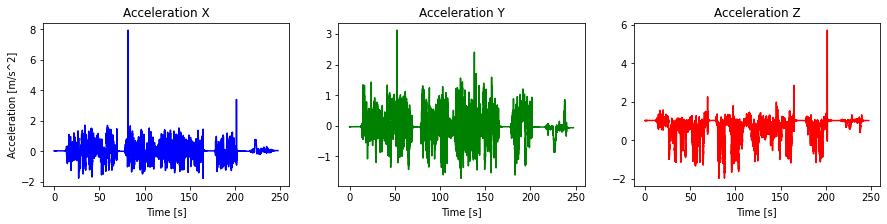

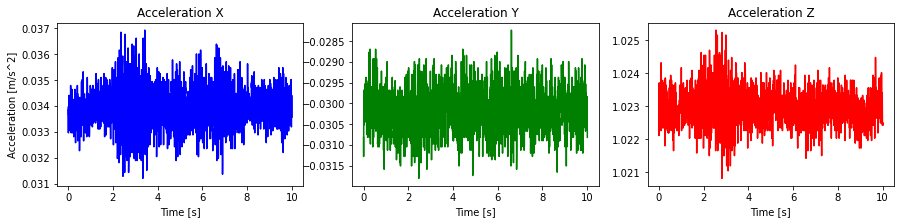

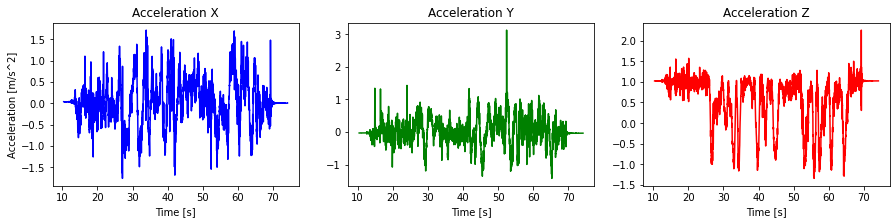

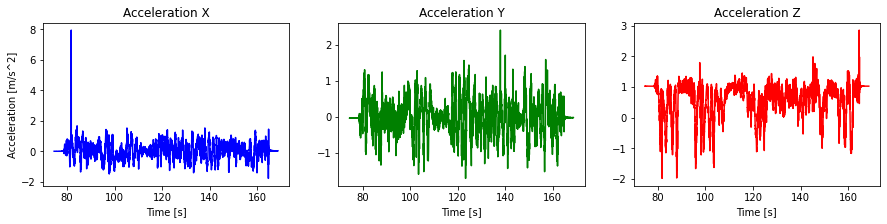

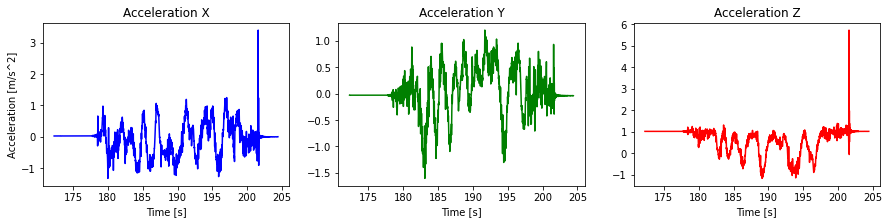

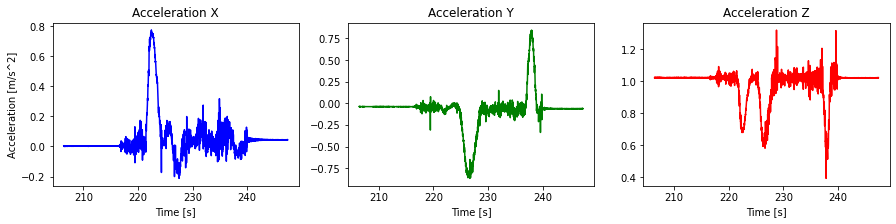

In [4]:
d.plotData(acc=True)
d_stand.plotData(acc=True)
d_calib.plotData(acc=True)
d_train.plotData(acc=True)
d_valid.plotData(acc=True)
d_test.plotData(acc=True)

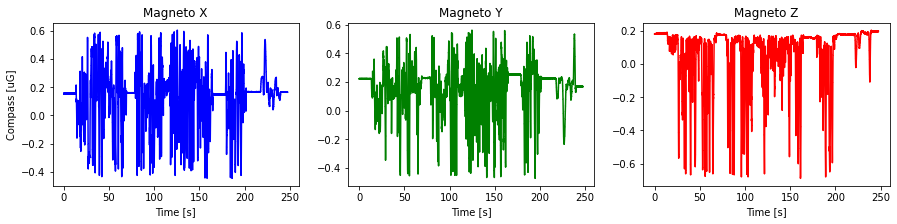

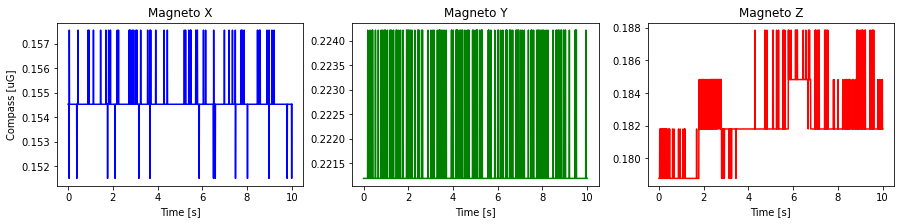

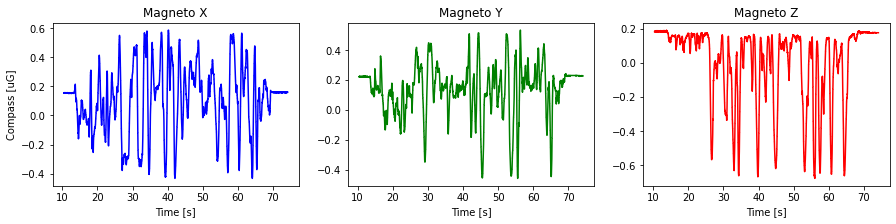

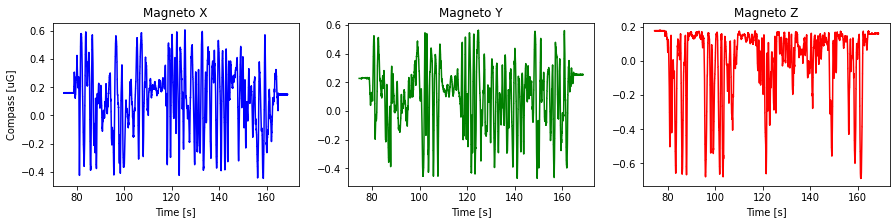

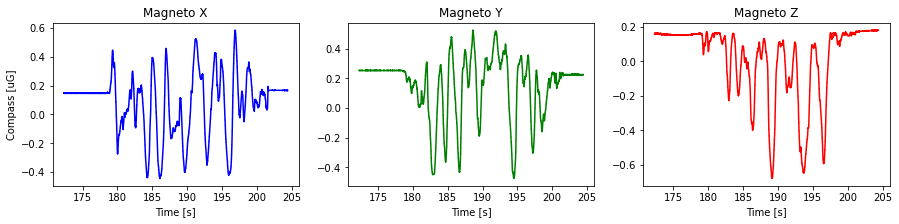

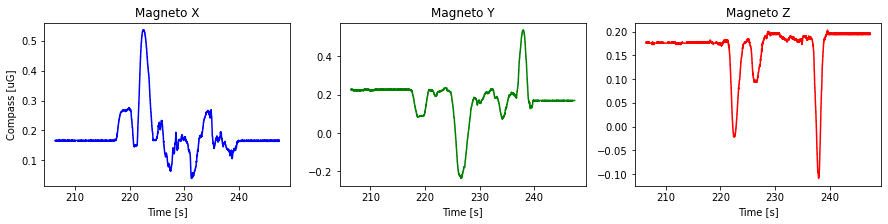

In [5]:
d.plotData(mag=True)
d_stand.plotData(mag=True)
d_calib.plotData(mag=True)
d_train.plotData(mag=True)
d_valid.plotData(mag=True)
d_test.plotData(mag=True)

In [6]:
d.showHeader()

0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - MARG_posX
11 - MARG_posY
12 - MARG_posZ
13 - MARG_quatX
14 - MARG_quatY
15 - MARG_quatZ
16 - MARG_quatW
17 - MARG_rotX
18 - MARG_rotY
19 - MARG_rotZ


In [ ]:
d.filterData(51, 'bartlett', [1, 2, 3]) # filter Acc
d.filterData(51, 'hanning', [4, 5, 6]) # filter Gyro
d.filterData(51, 'hanning', [7, 8, 9]) # filter Mag
d.plotData(acc=True,gyro=True,mag=True)

e.filterData(51, 'bartlett', [1, 2, 3]) # filter Acc
e.filterData(51, 'hanning', [4, 5, 6]) # filter Gyro
e.filterData(51, 'hanning', [7, 8, 9]) # filter Mag
e.plotData(acc=True,gyro=True,mag=True)

# Data operations for successful Madgwick

In [7]:
Acc    = d_test.data[:,1:4]
Gyro   = d_test.data[:,4:7]
Mag    = d_test.data[:,7:10]
MocapQ = d_test.data[:,13:17]
MocapE = d_test.data[:,17:20]

print('Acc shape:     ' + str(Acc.shape))
print('Gyro shape:    ' + str(Gyro.shape))
print('Mag shape:     ' + str(Mag.shape))
print('MocapQ shape:  ' + str(MocapQ.shape))
print('MocapE shape:  ' + str(MocapE.shape))

Acc shape:     (10220, 3)
Gyro shape:    (10220, 3)
Mag shape:     (10220, 3)
MocapQ shape:  (10220, 4)
MocapE shape:  (10220, 3)


In [8]:
MadgwickQ = ahrs.filters.Madgwick(acc=Acc*9.8077, gyr=Gyro/57.3, mag=Mag*10, gain=0.000001, Dt=0.004)
#az itteni beszorzások nekem segítettek az eredményekkel
print('MadgwickQ shape: ' + str(MadgwickQ.Q.shape))  

MadgwickQ shape: (10220, 4)


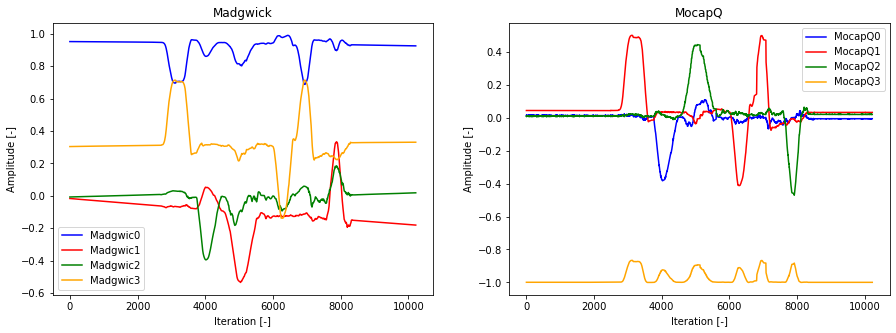

In [9]:
plt.figure(3, figsize=(15, 5))
plt.subplot(121)
plt.title("Madgwick")
plt.plot(MadgwickQ.Q[:,0], color='blue', label='Madgwic0')
plt.plot(MadgwickQ.Q[:,1], color='red', label='Madgwic1')
plt.plot(MadgwickQ.Q[:,2], color='green', label='Madgwic2')
plt.plot(MadgwickQ.Q[:,3], color='orange', label='Madgwic3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(122)
plt.title("MocapQ")
plt.plot(MocapQ[:,0], color='blue', label='MocapQ0')
plt.plot(MocapQ[:,1], color='red', label='MocapQ1')
plt.plot(MocapQ[:,2], color='green', label='MocapQ2')
plt.plot(MocapQ[:,3], color='orange', label='MocapQ3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
plt.show()

plt.show()

In [ ]:
MocapQ  = w_flip(MocapQ) #x,y,z,w -> w,x,y,z
MadgwickQ.Q = w_flip(MadgwickQ.Q) #x,y,z,w -> w,x,y,z

# mocap tengelyeit fogjuk forgatni
MocapQ = MOC_to_MAD(MocapQ) #w,x,y,z -> w,y,-x,-z

In [ ]:
# distance check:
distance_check(MocapQ, MadgwickQ.Q)

In [ ]:
# if there are sudden changes:
MocapQ = mocap_correction(MocapQ)
distance_check(MocapQ, MadgwickQ.Q)

#the correction looks okay

In [ ]:
#checking for consistent distance again

from pyquaternion import Quaternion
distance=np.zeros(d.data.shape[0])
time=[]
for i in range(d.data.shape[0]):
    time.append(i*0.004)

for i in range(d.data.shape[0]): # az egész adathalmazra nézve megézi a quaternio távolságokat
    q1 = Quaternion(MadgwickQ.Q[i][0],MadgwickQ.Q[i][1],MadgwickQ.Q[i][2],MadgwickQ.Q[i][3])
    q2 = Quaternion(MocapQ[i][0],MocapQ[i][1],MocapQ[i][2],MocapQ[i][3])
    
    
    distance[i]=Quaternion.distance(q1,q2)
plt.plot(time,distance)


In [ ]:
#putting back the data, so that the trnasformer network can have the same target values
   # i dont really need this right now
d.data[:,13] =np.array(MocapQ[:,1])
d.data[:,14] =np.array(MocapQ[:,2])
d.data[:,15] =np.array(MocapQ[:,3]) 
d.data[:,16] =np.array(MocapQ[:,0]) 
'''
MocapQ2 = d.data[:,13:17] #making sure, that it is done

for i in range(d.data.shape[0]): 
    q1 = Quaternion(MocapQ[i])
    q2 = Quaternion(MocapQ2[i])
    
    
    distance[i]=Quaternion.distance(q1,q2)
plt.plot(time,distance)
''';

In [ ]:
# madgwickből mocapbe
solution = transform(MocapQ, MadgwickQ.Q, axis="MOC", n=100)  
                    #mibe, <- mit, axis = melyiknek forgattuk a tengelyeit,n = hánynak az átlagát vettük
print (solution)
time=np.zeros(len(MocapQ))

Moctest=np.zeros((len(MocapQ),4))
distance=np.zeros(len(MocapQ))

for i in range(d.data.shape[0]): # quaterniok átfordítása
    time[i] = i*0.004
    
    q10=turn(solution, MadgwickQ.Q[i], axis ="MOC") # fogató quat, mit forgat, axis = melyiknek forgattuk a tengelyeit
    Moctest[i]=q10
    
    q1 = Quaternion(q10[0],q10[1],q10[2],q10[3])
    q2 = Quaternion(MocapQ[i][0],MocapQ[i][1],MocapQ[i][2],MocapQ[i][3])
    
    distance[i]=Quaternion.sym_distance(q1,q2)

In [ ]:
#plottolás
plt.figure(1, figsize=(15, 3))

plt.subplot(121)
plt.title("quat-0")
plt.plot(time,Moctest[:,0],label='madgwickbol')
plt.plot(time,MocapQ[:,0],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-1")
plt.plot(time,Moctest[:,1],label='madgwickbol')
plt.plot(time,MocapQ[:,1],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(2, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-2")
plt.plot(time,Moctest[:,2],label='madgwickbol')
plt.plot(time,MocapQ[:,2],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-3")
plt.plot(time,Moctest[:,3],label='madgwickbol')
plt.plot(time,MocapQ[:,3],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(3, figsize=(15, 3))
plt.subplot(111)
plt.title("distance")
plt.plot(time,distance)
plt.xlabel('time [-]')
plt.ylabel('distance [-]')
plt.show()

## a mocap adatai: MocapQ, a Madgwickből transzformálva: Moctest

# Data operations for Transformer Network

In [ ]:
# Transformernek kell: mocap eredeti: x,y,z,w ebből kéne: y,-x,-z,w

In [ ]:
'''
d.addFeature(MARG_quatW, MARG_quatY, MARG_quatX, MARG_quatZ)
# jó a sorrend

#=================================

Madgwick = d.data[:, 20:] 
Madgwick[:, -1] = -1 * Madgwick[:, -1]
Madgwick[:, -2] = -1 * Madgwick[:, -2]
''';

In [ ]:
#alternatív esetben:w,x,y,z,w ->  y,-x,-z,w     
tmpX =np.array(e.data[:,13]) #x
tmpY =np.array(e.data[:,14]) #y
tmpZ =np.array(e.data[:,15]) #z
print(e.data[:,13:16])


e.data[:,13] =np.array(tmpY)
e.data[:,14] =np.array(-1*tmpX)
e.data[:,15] =np.array(-1*tmpZ) 
print(e.data[:,13:16])
'''
tmpX =np.array(d.data[:,13]) #x
tmpY =np.array(d.data[:,14]) #y
tmpZ =np.array(d.data[:,15]) #z

d.data[:,13] =np.array(tmpY)
d.data[:,14] =np.array(-1*tmpX)
d.data[:,15] =np.array(-1*tmpZ) 

# ide még kéne az esetleges mocap fordító
''';

In [ ]:
d.addFeature(['diff_Timestamp'])
e.addFeature(['diff_Timestamp'])

d.showHeader()

In [ ]:
# Actual input and label data for the training. The columns defined in data_const will be constat in each sequence (first value)
data = [20,1,2,3,4,5,6,7,8,9] #don't put diff_position here! 
#data_const = [-3,-2,-1]
data_const = []

label = [13,14,15,16] # új w,x,y,z -> w,y,-x,-z

num_layers = 2
d_model = 32
dff = 128
num_heads = 8
input_size = len(data)
target_size = len(label)
dropout_rate = 0.1

in_seq_len = 128
tar_seq_len = 2
batch_size = 64

In [ ]:
#d.filterData(5, 'hanning', [24, 25, 26])

In [ ]:
# Parsing the data 
# =============Training data========================
X_alap, X_header, _, _ = d.dataParser(data, [], in_seq_len, data_const)
_, _, Y_alap, Y_header = d.dataParser([], label, tar_seq_len)
Y_alap = Y_alap[in_seq_len-tar_seq_len:,:,:]

nx = Normalizer()
ny = Normalizer()

X_norm = nx.normalize(X_alap)
Y_norm = ny.normalize(Y_alap)

# Batching the data
batcher = Batcher(batch_size, shuffle=True)
X = batcher.batch(X_norm) # training data
Y = batcher.batch(Y_norm)

# Dimension check
print('e.data: ', e.data.shape)
print('X_alap:   ', X_alap.shape, '   Y_alap: ', Y_alap.shape)
print('X_norm:   ', X_norm.shape, '   Y_norm: ', Y_norm.shape)
print('X:        ', X.shape,      ' Y:      ', Y.shape)

# ==================Testing data=====================

X_alap_T, X_header_T,_,_ = e.dataParser(data, [], in_seq_len, data_const)
_, _, Y_alap_T, Y_header_T = e.dataParser([], label, tar_seq_len)
Y_alap_T = Y_alap_T[in_seq_len-tar_seq_len:,:,:]

nx = Normalizer()
ny = Normalizer()

X_norm_T = nx.normalize(X_alap_T)
Y_norm_T = ny.normalize(Y_alap_T)

batcher = Batcher(batch_size, shuffle=True)

X_T = batcher.batch(X_norm_T) # test data
Y_T = batcher.batch(Y_norm_T)

# Dimension check
print('d.data: ', d.data.shape)
print('X_alap:   ', X_alap_T.shape, '   Y_alap: ', Y_alap_T.shape)
print('X_norm:   ', X_norm_T.shape, '   Y_norm: ', Y_norm_T.shape)
print('X:        ', X_T.shape,      ' Y:      ', Y_T.shape)


# transformer

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1/np.power(10000, (2*(i//2))/np.float32(d_model))
    return pos*angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:,np.newaxis],
                            np.arange(d_model)[np.newaxis,:],
                            d_model)
    angle_rads[:,0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:,1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis,...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size,size)),-1,0)
    return mask

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """
    
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    
    dk = tf.cast(tf.shape(k)[-1],tf.float32)
    scaled_attention_logits = matmul_qk/tf.math.sqrt(dk)
    
    if mask is not None:
        scaled_attention_logits += (mask* -1e9) # softmax az 1esek helyen kozel vegtelen negativ inputra kozel nulla outputot ad majd
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0,2,1,3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q,k,v,mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])
        concat_attention = tf.reshape(scaled_attention, (batch_size,-1, self.d_model))
        
        output = self.dense(concat_attention)
        
        return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation = "relu"),
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model,dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x,x,x,mask)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(x+attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        out2 = self.layernorm2(out1+ffn_output)
        
        return out2   

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask):
        attn1, attn_weights_block1 = self.mha1(x,x,x,look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1+x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, None)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2+out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output+out2)
        
        return out3, attn_weights_block1, attn_weights_block2 

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_size, 
                maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.redimension_layer = tf.keras.layers.Conv1D(d_model,3,padding="same")
        
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                          for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        x = self.redimension_layer(x)
        
        #Maybe: x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        #x = tf.reshape(x,(-1, seq_len, self.d_model))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
            
        return x  

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_size,
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.pos_encoding =positional_encoding(maximum_position_encoding, d_model)
        
        self.redimension_layer = tf.keras.layers.Conv1D(d_model,3,padding="same")
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                          for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask):
        attention_weights = {}
        seq_len = tf.shape(x)[1]
        
        x = self.redimension_layer(x)
        
        #Maybe: x*=tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        #x = tf.reshape(x,(-1, seq_len, self.d_model))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask)
            
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        
        return x, attention_weights    

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_size, target_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_size, pe_target, rate)
        
        self.final_layer = tf.keras.layers.Dense(target_size)
        
    def call(self, inp, tar, training, look_ahead_mask):
        enc_output = self.encoder(inp, training, None)
        
        dec_output, attention_weights = self.decoder(tar, enc_output, training,
                                                    look_ahead_mask)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step*(self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model)*tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model, warmup_steps=4000)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9,
                                     beta_2=0.98, epsilon=1e-9)

In [ ]:
def loss_function(real, pred):
    return tf.reduce_mean(tf.math.square(real-pred))

train_loss = tf.keras.metrics.Mean(name='train_loss')

In [ ]:
transformer = Transformer(num_layers,d_model, num_heads, dff,
                          input_size, target_size, pe_input=in_seq_len,
                         pe_target=tar_seq_len, rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    return look_ahead_mask

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

'''
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint restored")
''';

In [ ]:
#epochs = 16
epochs = 10


In [ ]:
train_step_signature =  [
    tf.TensorSpec(shape=(None, None, input_size), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None, target_size), dtype=tf.float32)
    ]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:,:-1,:]
    tar_real = tar[:, 1:,:]
    
    lookahead_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, lookahead_mask)
        
        loss = loss_function(tar_real, predictions)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)

In [ ]:
import time
for epoch in range(epochs):
    stime = time.time()
    
    train_loss.reset_states()
    
    for batch in range(X.shape[0]):
        inp = X[batch,:,:,:]
        tar = Y[batch,:,:,:]
        train_step(inp, tar)
        
        if batch % 50 ==0:
            print('Epoch {} Batch {} Loss {:.7f}'.format(
            epoch+1, batch, train_loss.result()
            ))
    
    if (epoch+1) %5 ==0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    print ('Epoch {} Loss {:.7f}'.format(epoch + 1, 
                                                train_loss.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - stime))

In [ ]:
stime=time.time()
idx = 2000
inp = X_norm_T[idx].reshape((1,in_seq_len,input_size))
tar = Y_norm_T[idx].reshape((1,tar_seq_len,target_size))
tar_inp = tar[:,:-1,:]
tar_last = Y_alap_T[idx,-1,:]
lookahead_mask = create_masks(inp, tar_inp)
pred, _ = transformer(inp, tar_inp, False, lookahead_mask)
denormed = ny.denormalize_prediction(pred)[0,-1,:]
print("Predicted: ", denormed,"\n\nReal: ",tar_last)
print(time.time()-stime)

In [ ]:
Xcoord = []
Ycoord = []
Zcoord = []
Wcoord=[]
Xdiff = []
Ydiff = []
Zdiff = []
Wdiff=[]
maxsteps = 1000
times = np.arange(maxsteps)*0.004
for idx in range(maxsteps):
    #stime = time.time()
    inp = X_norm_T[idx].reshape((1,in_seq_len,input_size))
    tar = Y_norm_T[idx].reshape((1,tar_seq_len,target_size))
    tar_inp = tar[:,:-1,:]
    tar_last = Y_alap_T[idx,-1,:]
    lookahead_mask = create_masks(inp, tar_inp)
    pred, _ = transformer(inp, tar_inp, False, lookahead_mask)
    denormed = ny.denormalize_prediction(pred)[0,-1,:]
    #appendtime=time.time()
    Xcoord.append(denormed[0]) #x
    Ycoord.append(denormed[1]) #y
    Zcoord.append(denormed[2]) #z
    Wcoord.append(denormed[3]) #w
    diff = denormed-tar_last
    Xdiff.append(diff[0])
    Ydiff.append(diff[1])
    Zdiff.append(diff[2])
    Wdiff.append(diff[3])
    
    #print("Full: ",time.time()-stime,"  Append: ",time.time()-appendtime)

In [ ]:
MocapE = e.data[:,17:20]

In [ ]:
plt.figure(1,figsize=(12,4))
plt.title("Prediction error (latest ground truth values known)")
plt.plot(times, Xcoord)
plt.plot(times, Ycoord)
plt.plot(times, Zcoord)
plt.plot(times, Wcoord)
plt.ylabel("Difference [mm]")
plt.xlabel("Elapsed time [sec]")
plt.legend(["X","Y","Z","W"])
plt.grid()
'''
plt.figure(2,figsize=(12,8))
plt.title("Above view (latest ground truth values known)")
plt.plot(Xcoord, Ycoord)
plt.plot(Y_alap[:2000,-1,0],Y_alap[:2000,-1,1])
plt.ylabel("Y coordinate [mm]")
plt.xlabel("X coordinate [mm]")
plt.legend(["Predicted","Ground truth"])
plt.grid()
'''
distanceTM=np.zeros(maxsteps)
distanceMM=np.zeros(maxsteps)
for i in range(maxsteps): # quaterniok átfordítása
    
    q1 = Quaternion(Moctest[i+127,0],Moctest[i+127,1],Moctest[i+127,2],Moctest[i+127,3])
    q2 = Quaternion(MocapQ[i+127][0],MocapQ[i+127][1],MocapQ[i+127][2],MocapQ[i+127][3])
    q3 = Quaternion(Wcoord[i], Xcoord[i], Ycoord[i], Zcoord[i])
    
    
    distanceTM[i]=Quaternion.sym_distance(q3,q2)
    distanceMM[i]=Quaternion.sym_distance(q1,q2)
    
plt.figure(2,figsize=(12,4))
plt.plot(distanceTM, label="distance Transformer-MoCap")
plt.plot(distanceMM, label="distance Madgwick-MoCap")
plt.legend()
print("Madgwick:",np.average(distanceMM)," Transform:",np.average(distanceTM))

In [ ]:
times = np.arange(maxsteps)*0.004
#plottolás
plt.figure(1, figsize=(15, 5))

treshold = 127

plt.subplot(121)
plt.title("quat-0")
plt.plot(times[0:(maxsteps-treshold)],Moctest[treshold:maxsteps,0],label='madgwickbol',color='blue')
plt.plot(times[0:(maxsteps-treshold)],MocapQ[treshold:maxsteps,0],label='mocap', color='red')
plt.plot(times, Wcoord, label='transformer',color='green')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-1")
plt.plot(times[0:(maxsteps-treshold)],Moctest[treshold:maxsteps,1],label='madgwickbol',color='blue')
plt.plot(times[0:(maxsteps-treshold)],MocapQ[treshold:maxsteps,1],label='mocap', color='red')
plt.plot(times, Xcoord, label='transformer',color='green')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(2, figsize=(15, 5))

plt.subplot(121)
plt.title("quat-2")
plt.plot(times[0:(maxsteps-treshold)],Moctest[treshold:maxsteps,2],label='madgwickbol',color='blue')
plt.plot(times[0:(maxsteps-treshold)],MocapQ[treshold:maxsteps,2],label='mocap', color='red')
plt.plot(times, Ycoord, label='transformer',color='green')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-3")
plt.plot(times[0:(maxsteps-treshold)],Moctest[treshold:maxsteps,3],label='madgwickbol',color='blue')
plt.plot(times[0:(maxsteps-treshold)],MocapQ[treshold:maxsteps,3],label='mocap', color='red')
plt.plot(times, Zcoord, label='transformer',color='green')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()


# Euler
## MocapQ -> MocapE         Moctest -> MadEuler        coord -> TransformE

In [ ]:
import numpy as np #az importált q-->e fv

def quaternion_to_euler_angle_vectorized1(w, x, y, z):
    ysqr = y * y

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + ysqr)
    X = np.degrees(np.arctan2(t0, t1))

    t2 = +2.0 * (w * y - z * x)
    t2 = np.where(t2>+1.0,+1.0,t2)
    #t2 = +1.0 if t2 > +1.0 else t2

    t2 = np.where(t2<-1.0, -1.0, t2)
    #t2 = -1.0 if t2 < -1.0 else t2
    Y = np.degrees(np.arcsin(t2))

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (ysqr + z * z)
    Z = np.degrees(np.arctan2(t3, t4))

    return X, Y, Z 


In [ ]:
TransformE = np.zeros((maxsteps, 3))
MadEuler = np.zeros((maxsteps, 3))
for i in range(maxsteps):
    TransformE[i,:] = quaternion_to_euler_angle_vectorized1(Wcoord[i], -1*Ycoord[i], Xcoord[i], -1*Zcoord[i])
    MadEuler[i,:] = quaternion_to_euler_angle_vectorized1(Moctest[i+127,0], -1*Moctest[i+127,2], Moctest[i+127,1], -1*Moctest[i+127,3])
    
    
# ez maga az euler transzformációs algoritmus tesztelésére
# elvileg ha mocapQ-ból transzformálom akkor jobb lesz, valószínüleg kellene egy másik algoritmus, hogy az eredeti euler szögeket tudjuk használni
MocapE = d.data[:,17:20]

MocapE=np.zeros((maxsteps+127, 3))
for i in range(maxsteps):
    MocapE[i,:] = quaternion_to_euler_angle_vectorized1(MocapQ[i,0],-1*MocapQ[i,2],MocapQ[i,1],-1*MocapQ[i,3])



In [ ]:
distance_alfa_M=np.zeros((maxsteps))
distance_beta_M=np.zeros((maxsteps))
distance_gamma_M=np.zeros((maxsteps))
for i in range(maxsteps):
    distance_alfa_M[i]= MocapE[i+127,0] - MadEuler[i,0]
    if (distance_alfa_M[i] > 180):
        distance_alfa_M[i]-=360
    if (distance_alfa_M[i] < -180):
        distance_alfa_M[i]+=360
    distance_beta_M[i]= MocapE[i+127,1] - MadEuler[i,1]
    if (distance_beta_M[i] > 180):
        distance_beta_M[i]-=360
    if (distance_beta_M[i] < -180):
        distance_beta_M[i]+=360
    distance_gamma_M[i]= MocapE[i+127,2] - MadEuler[i,2]
    if (distance_gamma_M[i] > 180):
        distance_gamma_M[i]-=360
    if (distance_gamma_M[i] < -180):
        distance_gamma_M[i]+=360
    
distance_alfa_T=np.zeros((maxsteps))
distance_beta_T=np.zeros((maxsteps))
distance_gamma_T=np.zeros((maxsteps))
for i in range(maxsteps-128):
    distance_alfa_T[i]= MocapE[i+127,0] - TransformE[i,0]
    if (distance_alfa_T[i] > 180):
        distance_alfa_T[i]-=360
    if (distance_alfa_T[i] < -180):
        distance_alfa_T[i]+=360
    distance_beta_T[i]= MocapE[i+127,1] - TransformE[i,1]
    if (distance_beta_T[i] > 180):
        distance_beta_T[i]-=360
    if (distance_beta_T[i] < -180):
        distance_beta_T[i]+=360
    distance_gamma_T[i]= MocapE[i+127,2] - TransformE[i,2]
    if (distance_gamma_T[i] > 180):
        distance_gamma_T[i]-=360
    if (distance_gamma_T[i] < -180):
        distance_gamma_T[i]+=360

In [ ]:
plt.title("Euler_0")
plt.plot(MocapE[0+127:maxsteps+127,0], color='red', label='MocapE')
plt.plot(MadEuler[0:maxsteps,0], color='blue', label='Madgwick')
plt.plot(TransformE[:,0], color='green', label='Transform')
plt.xlabel('Iteration [-]')
plt.ylabel('Rotation [°]')
plt.legend()
plt.show()

plt.title("Euler_1")
plt.plot(MocapE[0+127:maxsteps+127,1], color='red', label='MocapE')
plt.plot(MadEuler[0:maxsteps,1], color='blue', label='Madgwick')
plt.plot(TransformE[:,1], color='green', label='Transform')
plt.xlabel('Iteration [-]')
plt.ylabel('Rotation [°]')
plt.legend()
plt.show()

plt.title("Euler_2")
plt.plot(MocapE[0+127:maxsteps+127,2], color='red', label='MocapE')
plt.plot(MadEuler[0:maxsteps,2], color='blue', label='Madgwick')
plt.plot(TransformE[:,2], color='green', label='Transform')
plt.xlabel('Iteration [-]')
plt.ylabel('Rotation [°]')
plt.legend()
plt.show()


In [ ]:
plt.figure(1, figsize=(15, 15))

plt.subplot(311)

plt.title("euler_mistake_alfa")
plt.plot(distance_alfa_M, color='green', label='alfa_M')
plt.plot(distance_alfa_T, color='blue', label='alfa_T')
plt.xlabel('Iteration [-]')
plt.ylabel( 'difference[°]')
plt.legend()
plt.show()

plt.figure(1, figsize=(15, 15))

plt.subplot(312)
plt.title("euler_mistake_beta")
plt.plot(distance_beta_M, color='green', label='beta_M')
plt.plot(distance_beta_T, color='blue', label='beta_T')
plt.xlabel('Iteration [-]')
plt.ylabel( 'difference[°]')
plt.legend()
plt.show()

plt.figure(1, figsize=(15, 15))

plt.subplot(313)
plt.title("euler_mistake_gamma")
plt.plot(distance_gamma_M, color='green', label='gamma_M')
plt.plot(distance_gamma_T, color='blue', label='gamma_T')
plt.xlabel('Iteration [-]')
plt.ylabel( 'difference[°]')
plt.legend()
plt.show()


avg_gamma_M = np.average(np.abs(distance_gamma_M))
avg_beta_M = np.average(np.abs(distance_beta_M))
avg_alfa_M = np.average(np.abs(distance_alfa_M))

avg_gamma_T = np.average(np.abs(distance_gamma_T))
avg_beta_T = np.average(np.abs(distance_beta_T))
avg_alfa_T = np.average(np.abs(distance_alfa_T))

print('average differences Madgwick')
print('alfa_M:',avg_alfa_M,'  beta_M:',avg_beta_M, '  gamma_M:', avg_gamma_M)


print('average differences Transform')
print('alfa_T:',avg_alfa_T,'  beta_T:',avg_beta_T, '  gamma_T:', avg_gamma_T)